<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/diff-aug/Evaluate_TransGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
# Check GPU
!nvidia-smi

Tue Apr 13 18:53:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   45C    P2    25W / 120W |    664MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import sys
import pdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# from torchsummary import summary
from types import SimpleNamespace

In [ ]:
from models.transformer_generator import TGenerator
from models.ViT_discriminator import Discriminator
from utils.utils import check_gpu, display_images, set_seed
from utils.checkpoint import Checkpoint
from utils.loss import wgangp_eps_loss
from utils.datasets import ImageDataset
%load_ext autoreload
%autoreload 2

In [ ]:
gdrive = Path('C:\\GANs\\')

In [ ]:
# seed notebook
set_seed(seed=123)
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [ ]:
!set PYTHONPATH=%PYTHONPATH%;C:/GitHub/GANs && python ./scripts/create_fid_stats.py -d cifar_10 -t False

Namespace(batch_size=256, dataset='cifar_10', save='fid_stats', train='False')
Files already downloaded and verified
fid_stats\cifar_10_valid_fid_stats.npz exists. Exiting !!!


# Training

In [ ]:
gen_batch_sz = 64
dis_batch_sz = 32
latent_dims = 1024
lr, beta1, beta2 = 1e-4, 0, 0.999
num_epochs = 20

In [ ]:
# Add Horizontal Flip by default
tfms = [transforms.RandomHorizontalFlip()]
dataset =  ImageDataset('cifar_10', batch_sz=dis_batch_sz, tfms=tfms, 
                        num_workers=2, drop_last=True)
# display_images(dataset.train_loader)

Files already downloaded and verified


In [ ]:
Gen = TGenerator(latent_dims=latent_dims).to(device)
fixed_z = torch.randn(gen_batch_sz, latent_dims, device=device)
# summary(Gen,(latent_dims,))

In [ ]:
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args).to(device)
# summary(Dis,(3,32,32,))

In [ ]:
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
from metrics.torch_is_fid_score import is_fid_from_generator

stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
experiments = ['no_aug', 'flip_lr', 'full_aug']
epochs = [[] for i in range(len(experiments))]
fids = [[] for i in range(len(experiments))]
iss = [[] for i in range(len(experiments))]

for idx, exp in enumerate(experiments):
  ckp_folder = gdrive/exp
  for filename in os.listdir(ckp_folder):
      epoch = int(filename[:-4].split('_')[-1])
      
      Gen, Dis, optG, optD, start_epoch, old_logs = \
          Checkpoint.load_checkpoint(ckp_folder/filename, Gen, Dis, optG, optD)
      assert start_epoch > 0
      
      inception_score, fid = is_fid_from_generator(generator=Gen,
                                              latent_dims=latent_dims,
                                              num_imgs=10000,
                                              batch_sz=64,
                                              fid_stat_path = stat_path)
      print(fid)
      iss[idx].append(inception_score)
      fids[idx].append(fid)
      epochs[idx].append(epoch)


=> Loading checkpoint: C:\GANs\no_aug\GanModel_010.pth


85.31027221679688
=> Loading checkpoint: C:\GANs\no_aug\GanModel_020.pth


77.84417724609375
=> Loading checkpoint: C:\GANs\no_aug\GanModel_030.pth


82.09933471679688
=> Loading checkpoint: C:\GANs\no_aug\GanModel_040.pth


232.72918701171875
=> Loading checkpoint: C:\GANs\no_aug\GanModel_050.pth


nan
=> Loading checkpoint: C:\GANs\no_aug\GanModel_060.pth


197.93804931640625
=> Loading checkpoint: C:\GANs\no_aug\GanModel_070.pth


99.60061645507812
=> Loading checkpoint: C:\GANs\no_aug\GanModel_080.pth


108.93743896484375
=> Loading checkpoint: C:\GANs\no_aug\GanModel_090.pth


114.71224975585938
=> Loading checkpoint: C:\GANs\no_aug\GanModel_095.pth


117.01568603515625
=> Loading checkpoint: C:\GANs\no_aug\GanModel_100.pth


92.58587646484375
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_005.pth


102.4156494140625
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_010.pth


79.74346923828125
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_015.pth


87.42034912109375
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_020.pth


69.9796142578125
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_025.pth


89.114013671875
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_030.pth


73.52703857421875
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_035.pth


72.68161010742188
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_040.pth


88.54913330078125
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_045.pth


80.76718139648438
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_050.pth


80.52609252929688
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_055.pth


86.01220703125
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_060.pth


75.0709228515625
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_065.pth


93.28558349609375
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_070.pth


114.5699462890625
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_075.pth


87.01593017578125
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_080.pth


187.17257690429688
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_085.pth


79.52197265625
=> Loading checkpoint: C:\GANs\flip_lr\GanModel_090.pth


76.36215209960938
=> Loading checkpoint: C:\GANs\full_aug\GanModel_002.pth


151.31887817382812
=> Loading checkpoint: C:\GANs\full_aug\GanModel_006.pth


110.2109375
=> Loading checkpoint: C:\GANs\full_aug\GanModel_011.pth


93.86993408203125
=> Loading checkpoint: C:\GANs\full_aug\GanModel_015.pth


97.39678955078125
=> Loading checkpoint: C:\GANs\full_aug\GanModel_020.pth


89.481201171875
=> Loading checkpoint: C:\GANs\full_aug\GanModel_025.pth


68.44229125976562
=> Loading checkpoint: C:\GANs\full_aug\GanModel_030.pth


69.9837646484375
=> Loading checkpoint: C:\GANs\full_aug\GanModel_036.pth


78.97940063476562
=> Loading checkpoint: C:\GANs\full_aug\GanModel_041.pth


82.09146118164062
=> Loading checkpoint: C:\GANs\full_aug\GanModel_046.pth


67.86721801757812
=> Loading checkpoint: C:\GANs\full_aug\GanModel_052.pth


65.057373046875
=> Loading checkpoint: C:\GANs\full_aug\GanModel_057.pth


55.19476318359375
=> Loading checkpoint: C:\GANs\full_aug\GanModel_062.pth


62.72979736328125
=> Loading checkpoint: C:\GANs\full_aug\GanModel_068.pth


49.853118896484375
=> Loading checkpoint: C:\GANs\full_aug\GanModel_073.pth


52.55169677734375
=> Loading checkpoint: C:\GANs\full_aug\GanModel_078.pth


65.23220825195312
=> Loading checkpoint: C:\GANs\full_aug\GanModel_084.pth


52.306640625
=> Loading checkpoint: C:\GANs\full_aug\GanModel_089.pth


54.709747314453125


# Analysis

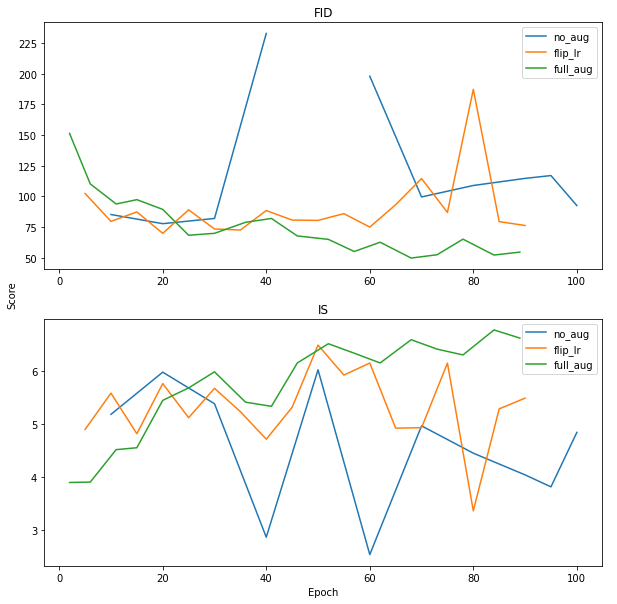

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for idx, exp in enumerate(experiments):
  e = epochs[idx]
  fid = fids[idx]
  inception_score = iss[idx]
  score = [s[0] for s in inception_score]

  axs[0].plot(e,fid,label=exp)
  axs[0].set_title('FID')
  
  axs[1].plot(e,score, label=exp)
  axs[1].set_title('IS')

  plt.ylabel("Score")
  plt.xlabel("Epoch")

axs[0].legend()
axs[1].legend()
plt.show()

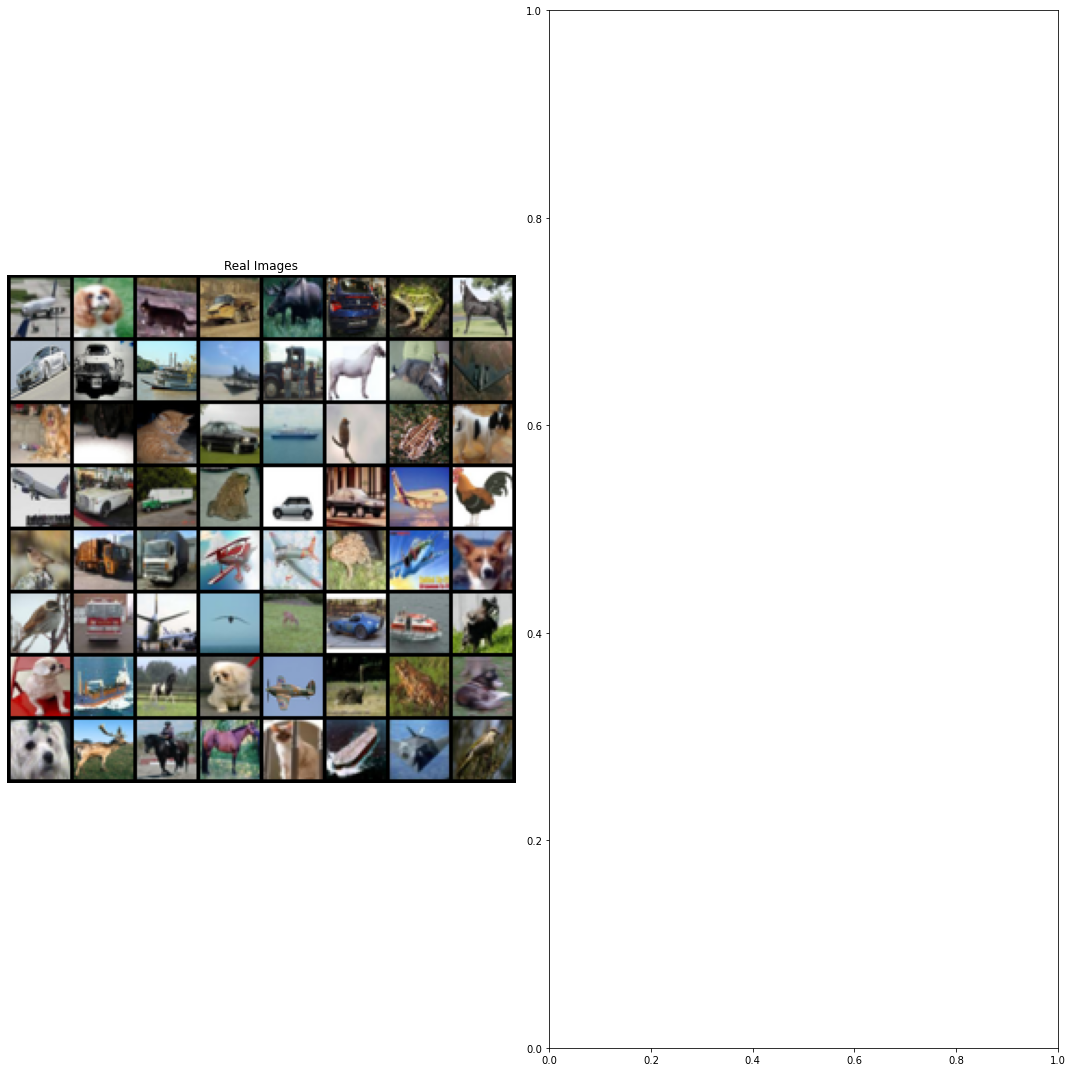

In [ ]:
_, axs = plt.subplots(1,2,figsize=(15,15))
display_images(dataset.train_loader,ax = axs[0])
# display_images(img_list, ax = axs[1])
plt.tight_layout()